In [539]:
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_csv("source.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head()

,characteristincs_balcony,characteristincs_yard,characteristincs_rooftop,characteristincs_garage,amenities_amoblado,amenities_cancha_paddle,amenities_cancha_tenis,amenities_gimnasio,amenities_hidromasaje,amenities_laundry,amenities_microcine,amenities_parrilla,amenities_piscina,amenities_sala_de_juegos,amenities_sauna,amenities_solarium,amenities_spa,amenities_sum,amenities_centros_comerciales_cercanos,amenities_parques_cercanos,amenities_escuelas_cercanas,amenities_estacionamiento_visitas,antiquity,price,ambience,bedrooms,bathrooms,surface_total,location_neighbourhood_Abasto,location_neighbourhood_Agronomía,location_neighbourhood_Almagro,location_neighbourhood_Almagro Norte,location_neighbourhood_Almagro Sur,location_neighbourhood_Balvanera,location_neighbourhood_Congreso,location_neighbourhood_Once,location_neighbourhood_Barracas,location_neighbourhood_Barrio Norte,location_neighbourhood_La isla,location_neighbourhood_Parque las Heras,location_neighbourhood_Recoleta,location_neighbourhood_Belgrano,location_neighbourhood_Boedo,location_neighbourhood_Caballito,location_neighbourhood_Chacarita,location_neighbourhood_Coghlan,location_neighbourhood_Colegiales,location_neighbourhood_Constitución,location_neighbourhood_Flores,location_neighbourhood_Floresta,location_neighbourhood_La boca,location_neighbourhood_La paternal,location_neighbourhood_Liniers,location_neighbourhood_Mataderos,location_neighbourhood_Microcentro,location_neighbourhood_Monserrat,location_neighbourhood_Monte Castro,location_neighbourhood_Nuñez,location_neighbourhood_Palermo,location_neighbourhood_Parque Avellaneda,location_neighbourhood_Parque Centenario,location_neighbourhood_Parque Chacabuco,location_neighbourhood_Parque Chas,location_neighbourhood_Parque Patricios,location_neighbourhood_Pompeya,location_neighbourhood_Primera Junta,location_neighbourhood_Puerto Madero,location_neighbourhood_Retiro,location_neighbourhood_Saavedra,location_neighbourhood_San Cristobal,location_neighbourhood_San Nicolas,location_neighbourhood_San Telmo,location_neighbourhood_Velez Sarsfield,location_neighbourhood_Versalles,location_neighbourhood_Villa Crespo,location_neighbourhood_Villa del Parque,location_neighbourhood_Villa Devoto,location_neighbourhood_Villa General Mitre,location_neighbourhood_Villa Lugano,location_neighbourhood_Villa Luro,location_neighbourhood_Villa Ortuzar,location_neighbourhood_Villa Pueyrredon,location_neighbourhood_Villa Real,location_neighbourhood_Villa Riachuelo,location_neighbourhood_Villa Santa Rita,location_neighbourhood_Villa Soldati,location_neighbourhood_Villa Urquiza
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84.507042,2.0,1.0,1,33,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,70.422535,2.0,1.0,1,35,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,95.774648,3.0,2.0,1,70,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2500.000000,5.0,3.0,1,206,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,70.422535,4.0,3.0,1,89,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='surface_total', ylabel='price'>

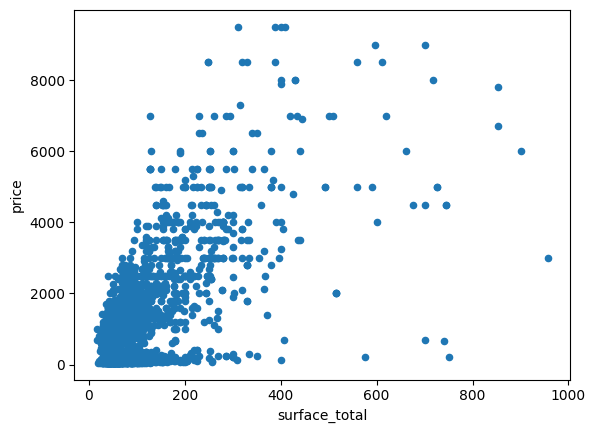

In [540]:
# Tenemos varios outliers en relación a superficie de los departamentos

#df = df.loc[df.surface_total < 300]

# Precio por superficie
var = 'surface_total'
data = pd.concat([df['price'], df[var]], axis=1)
data.plot.scatter(x=var, y='price')

In [541]:
from sklearn.model_selection import train_test_split
y = df.price
X = df.drop(["price"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [542]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Standard scaling of variables
#X_train[["surface_total", "ambience"]] = scaler.fit_transform(X_train[["surface_total", "ambience"]])
#X_test[["surface_total", "ambience"]] = scaler.fit_transform(X_test[["surface_total", "ambience"]])

In [543]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

-2020721708998.4766

In [544]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.0005)
lasso_model = lasso.fit(X_train, y_train)
lasso_model.score(X_test, y_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.569e+08, tolerance: 3.692e+05
  model = cd_fast.enet_coordinate_descent(


0.5604719602821167

In [545]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
enet_model = enet.fit(X_train, y_train)
enet_model.score(X_test, y_test)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.770e+08, tolerance: 3.692e+05
  model = cd_fast.enet_coordinate_descent(


0.5605507827800523

In [546]:
from sklearn.kernel_ridge import KernelRidge

krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
krr_model = krr.fit(X_train, y_train)
krr_model.score(X_test, y_test)

0.6276979642880364

In [547]:
from sklearn.ensemble import GradientBoostingRegressor

GBoost = GradientBoostingRegressor()
GBoost_model = GBoost.fit(X_train, y_train)
GBoost_model.score(X_test, y_test)

0.5951407831064762

In [548]:
from sklearn.ensemble import RandomForestRegressor

rforest = RandomForestRegressor(max_depth=2, random_state=0)
rforest_model = rforest.fit(X_train, y_train)
rforest_model.score(X_test, y_test)

0.5012163971667125

In [549]:
from sklearn.ensemble import HistGradientBoostingRegressor

HGBoost = HistGradientBoostingRegressor()
HGBoost_model = HGBoost.fit(X_train, y_train)
HGBoost_model.score(X_test, y_test)

0.5802218524704712

In [550]:
from sklearn.ensemble import BaggingRegressor

Bagging = BaggingRegressor()
Bagging_model = Bagging.fit(X_train, y_train)
Bagging_model.score(X_test, y_test)

0.5564445744042655

In [551]:
from sklearn.ensemble import AdaBoostRegressor

AdaBoost = AdaBoostRegressor()
AdaBoost_model = AdaBoost.fit(X_train, y_train)
AdaBoost_model.score(X_test, y_test)

0.529548846194331

In [552]:
from sklearn.ensemble import ExtraTreesRegressor

ExtraTrees = ExtraTreesRegressor()
ExtraTrees_model = ExtraTrees.fit(X_train, y_train)
ExtraTrees_model.score(X_test, y_test)

0.5137659294658501

In [553]:
from sklearn.ensemble import GradientBoostingRegressor

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =15)
GBoost_model = GBoost.fit(X_train, y_train)
GBoost_model.score(X_test, y_test)

0.6058630323226712

In [554]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

model = GradientBoostingRegressor()
grid = dict()
grid['random_state'] = [15]

#grid['loss'] = ["squared_error", "absolute_error", "huber", "quantile"]
grid['loss'] = ["absolute_error"]

#grid['max_features'] = ["sqrt", "log2"]
grid['max_features'] = ["sqrt"]

#grid['n_estimators'] = [500, 1000, 3000, 5000]
grid['n_estimators'] = [3000]

#grid['min_samples_split'] = [2, 5, 7, 10, 15]
grid['min_samples_split'] = [10]

#grid['min_samples_leaf'] = [2, 5, 7, 10, 15]
grid['min_samples_leaf'] = [15]

#grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1]
grid['learning_rate'] = [0.05]

#grid['subsample'] = [0.5, 0.7, 1.0]
grid['subsample'] = [1]

#grid['max_depth'] = [3, 5, 7, 9]
grid['max_depth'] = [4]


# Procedimiento de evaluación, utilizamos RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Definimos el procedimiento de grid search
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)

# Ejecutamos el grid search
grid_result = grid_search.fit(X, y)

# Vemos el resultado
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.574900 using {'learning_rate': 0.05, 'loss': 'absolute_error', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 3000, 'random_state': 15, 'subsample': 1}


In [556]:
test = X_test.sample(1)
prediction = GBoost_model.predict(test)
print(prediction)
test[["surface_total", "ambience", "bedrooms", "bathrooms"]]
#test_list = test.columns.tolist()
#print(test_list)

[701.40093207]


,surface_total,ambience,bedrooms,bathrooms
1862,48,2.0,1.0,1


In [557]:
# Vamos a persistir el modelo

import pickle
from joblib import dump, load

dump(GBoost_model, 'Models/gboost_model.joblib') 

['Models/gboost_model.joblib']

In [559]:
columns_list = X_test.columns.tolist()
print(columns_list)

['characteristincs_balcony', 'characteristincs_yard', 'characteristincs_rooftop', 'characteristincs_garage', 'amenities_amoblado', 'amenities_cancha_paddle', 'amenities_cancha_tenis', 'amenities_gimnasio', 'amenities_hidromasaje', 'amenities_laundry', 'amenities_microcine', 'amenities_parrilla', 'amenities_piscina', 'amenities_sala_de_juegos', 'amenities_sauna', 'amenities_solarium', 'amenities_spa', 'amenities_sum', 'amenities_centros_comerciales_cercanos', 'amenities_parques_cercanos', 'amenities_escuelas_cercanas', 'amenities_estacionamiento_visitas', 'antiquity', 'ambience', 'bedrooms', 'bathrooms', 'surface_total', 'location_neighbourhood_Abasto', 'location_neighbourhood_Agronomía', 'location_neighbourhood_Almagro', 'location_neighbourhood_Almagro Norte', 'location_neighbourhood_Almagro Sur', 'location_neighbourhood_Balvanera', 'location_neighbourhood_Congreso', 'location_neighbourhood_Once', 'location_neighbourhood_Barracas', 'location_neighbourhood_Barrio Norte', 'location_neigh